In [100]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

In [2]:
keras.utils.set_random_seed(13)

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
len(X_train), len(X_test)

(50000, 10000)

In [5]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.2,
                                                    random_state=13)

In [6]:
X_train = X_train/255
X_test = X_test/255
X_valid = X_valid/255

# Эксперимент 1
- Предобучить feature extractor вашей архитектуры на всем датасете с помощью Self-supervised learning без использования разметки
- Использовать предобученный feature extracor в архитектуре сети для обучения на 100% размеченной выборки

### Предобучаем feature_extractor

In [7]:
def load_imgs(imgs):
    '''
    Функция возвращает две рандомные четвертинки изображения
    '''
    inputs_first = []
    inputs_second = []
    outputs = []
    sec_coords = [[[0, 32],[0, 32]], [[0, 32],[32, 64]],
                  [[32, 64],[0, 32]], [[32, 64],[32, 64]]]
    for img in imgs:
        sect = [0, 1, 2, 3]
        img = tf.image.resize(img,[32*2, 32*2])
        sect1 = sect[np.random.randint(0, len(sect))]
        sect.pop(sect1)
        sect2 = sect[np.random.randint(0, len(sect))]
        first_img = img[sec_coords[sect1][0][0]:sec_coords[sect1][0][1],
                        sec_coords[sect1][1][0]:sec_coords[sect1][1][1]]
        second_img = img[sec_coords[sect2][0][0]:sec_coords[sect2][0][1],
                        sec_coords[sect2][1][0]:sec_coords[sect2][1][1]]
        inputs_first.append(first_img)
        inputs_second.append(second_img)
        outputs.append(sect2)

    return np.asarray(inputs_first), np.asarray(inputs_second), keras.utils.to_categorical(outputs, 4)

Сначала предобучим backbone на всем датасете, затем обучим модель на 100% данных

In [8]:
train_first, train_second, train_outputs = load_imgs(X_train)
valid_first, valid_second, valid_outputs = load_imgs(X_test)

In [9]:
len(train_first), len(train_second), len(train_outputs)

(50000, 50000, 50000)

In [10]:
train_first.shape

(50000, 32, 32, 3)

In [12]:
# backbone

backbone = Sequential()

backbone.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
backbone.add(BatchNormalization())
backbone.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
backbone.add(BatchNormalization())
backbone.add(MaxPool2D(pool_size=(2, 2)))
backbone.add(Dropout(0.25))
backbone.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
backbone.add(BatchNormalization())
backbone.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
backbone.add(BatchNormalization())
backbone.add(MaxPool2D(pool_size=(2, 2)))
backbone.add(Dropout(0.25))
backbone.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
backbone.add(BatchNormalization())
backbone.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
backbone.add(BatchNormalization())
backbone.add(MaxPool2D(pool_size=(2, 2)))

backbone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [14]:
#SSL model
inputs1 = keras.Input(shape = (32,32,3), name='first_img')
inputs2 = keras.Input(shape = (32,32,3), name='second_img')
backbone1 = backbone(inputs1)
backbone2 = backbone(inputs2)
inputs = keras.layers.Concatenate()([backbone1, backbone2])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(4, activation='softmax', name='Output')(x)

ssl_model = keras.models.Model(inputs = [inputs1, inputs2], outputs = outputs)
ssl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 first_img (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 second_img (InputLayer)     [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 4, 4, 128)            288800    ['first_img[0][0]',           
                                                                     'second_img[0][0]']          
                                                                                                  
 concatenate (Concatenate)   (None, 4, 4, 256)            0         ['sequential[0][0]',      

In [15]:
ssl_model.compile(keras.optimizers.legacy.Adam(0.0005),
                  loss="categorical_crossentropy",
                  metrics=[keras.metrics.F1Score(average = 'weighted'),
                           keras.metrics.Precision(),
                           keras.metrics.Recall(),
                           keras.metrics.Accuracy()])

In [16]:
ssl_model.fit({'first_img':train_first,
               'second_img':train_second},
              train_outputs,
              validation_data=({'first_img':valid_first,
                                'second_img':valid_second},
                               valid_outputs),
              batch_size=256,
              epochs=25)

Epoch 1/25
196/196 [==============================] - 25s 85ms/step - loss: 1.2206 - f1_score: 0.5124 - precision: 0.6307 - recall: 0.3476 - accuracy: 7.5000e-05 - val_loss: 1.7976 - val_f1_score: 0.2613 - val_precision: 0.3532 - val_recall: 0.2460 - val_accuracy: 0.0000e+00
Epoch 2/25
196/196 [==============================] - 14s 73ms/step - loss: 0.7407 - f1_score: 0.6984 - precision: 0.7603 - recall: 0.6269 - accuracy: 0.0000e+00 - val_loss: 0.6582 - val_f1_score: 0.7388 - val_precision: 0.7958 - val_recall: 0.6625 - val_accuracy: 0.0000e+00
Epoch 3/25
196/196 [==============================] - 14s 73ms/step - loss: 0.6209 - f1_score: 0.7520 - precision: 0.7992 - recall: 0.7000 - accuracy: 0.0000e+00 - val_loss: 0.5785 - val_f1_score: 0.7770 - val_precision: 0.8202 - val_recall: 0.7255 - val_accuracy: 0.0000e+00
Epoch 4/25
196/196 [==============================] - 14s 73ms/step - loss: 0.5062 - f1_score: 0.8008 - precision: 0.8332 - recall: 0.7681 - accuracy: 5.0000e-06 - val_loss

In [17]:
# сохраним веса для нашего feature extractor
backbone.save_weights('weights/backbone')

In [18]:
# Подготовим данные для обучения
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

In [19]:
X_dataset_train = tf.data.Dataset.from_tensor_slices(X_train)
y_dataset_train = tf.data.Dataset.from_tensor_slices(y_train)

dataset_train = tf.data.Dataset.zip((X_dataset_train, y_dataset_train))

In [20]:
X_dataset_valid = tf.data.Dataset.from_tensor_slices(X_valid)
y_dataset_valid = tf.data.Dataset.from_tensor_slices(y_valid)

dataset_valid = tf.data.Dataset.zip((X_dataset_valid, y_dataset_valid))

In [21]:
dataset_train = dataset_train.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
X_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
y_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)

dataset_test = tf.data.Dataset.zip((X_dataset_test, y_dataset_test))
dataset_test = dataset_test.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

Используем предобученный feature extractor для обучения на всем датасете

In [31]:
# Загрузим веса для backbone
backbone.load_weights('weights/backbone')

In [32]:
# Классификатор

inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(128, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.25)(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

first_model = keras.models.Model(inputs = inputs, outputs = output)
first_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 4, 4, 128)         288800    
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 Dense_1 (Dense)             (None, 128)               262272    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 552362 (2.11 MB)
Trainable params: 551466 (2.

In [33]:
first_model.compile(keras.optimizers.legacy.Adam(0.0005), loss="categorical_crossentropy",
                    metrics=[keras.metrics.F1Score(name='f1_1'),
                             keras.metrics.Precision(name='precision_1'),
                             keras.metrics.Recall(name='recall_1'),
                             keras.metrics.Accuracy(name='accuracy_1')])

In [34]:
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/Exp_1")

In [35]:
%%time
history_1 = first_model.fit(dataset_train,
                            validation_data=dataset_valid,
                            epochs=50,
                            callbacks=[learn_rate_red, early_stop])

Epoch 1/50
196/196 [==============================] - 10s 43ms/step - loss: 1.4645 - f1_1: 0.4861 - precision_1: 0.6630 - recall_1: 0.3203 - accuracy_1: 0.0000e+00 - val_loss: 1.0926 - val_f1_1: 0.6010 - val_precision_1: 0.7289 - val_recall_1: 0.4910 - val_accuracy_1: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/50
196/196 [==============================] - 8s 42ms/step - loss: 1.0346 - f1_1: 0.6336 - precision_1: 0.7659 - recall_1: 0.5103 - accuracy_1: 0.0000e+00 - val_loss: 0.9564 - val_f1_1: 0.6664 - val_precision_1: 0.7639 - val_recall_1: 0.5690 - val_accuracy_1: 0.0000e+00 - lr: 5.0000e-04
Epoch 3/50
196/196 [==============================] - 8s 40ms/step - loss: 0.8818 - f1_1: 0.6860 - precision_1: 0.7982 - recall_1: 0.5857 - accuracy_1: 4.0000e-06 - val_loss: 0.8804 - val_f1_1: 0.6938 - val_precision_1: 0.7767 - val_recall_1: 0.6127 - val_accuracy_1: 0.0000e+00 - lr: 5.0000e-04
Epoch 4/50
196/196 [==============================] - 8s 41ms/step - loss: 0.7791 - f1_1: 0.7234 - precision_1:

In [36]:
eval_hist_1 = first_model.evaluate(dataset_test)

8/8 [==============================] - 0s 14ms/step - loss: 0.6963 - f1_1: 0.8044 - precision_1: 0.8225 - recall_1: 0.7925 - accuracy_1: 0.0034


In [37]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_1[0],
                                                                                      eval_hist_1[1],
                                                                                      eval_hist_1[2],
                                                                                      eval_hist_1[3]))

Eval_loss = 0.6963203549385071 
Eval_f1 = [0.8787185  0.90547264 0.71844655 0.6128266  0.73913044 0.68217057
 0.8599034  0.8357349  0.8981723  0.9137529 ] 
Eval_precision = 0.8225220441818237 
Eval_recall = 0.7925000190734863


#### Графики эксперимент 1

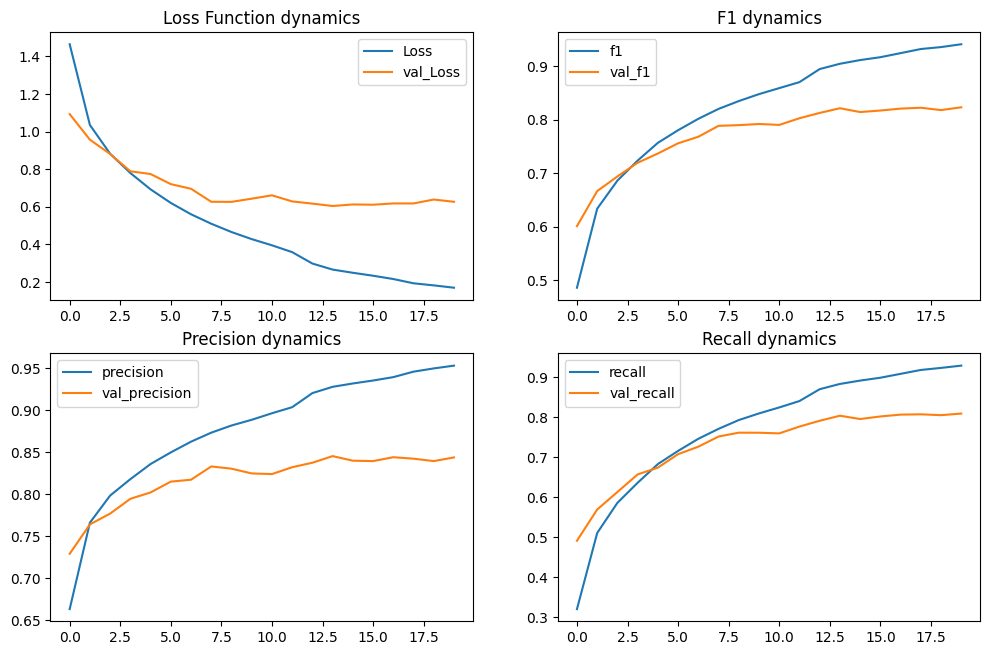

In [95]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_1.history['loss'], label='Loss')
plt.plot(history_1.history['val_loss'], label='val_Loss')
plt.title('Loss Function dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot((np.mean(history_1.history['f1_1'],axis = 1)), label='f1')
plt.plot((np.mean(history_1.history['val_f1_1'],axis = 1)), label='val_f1')
plt.title('F1 dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_1.history['precision_1'], label='precision')
plt.plot(history_1.history['val_precision_1'], label='val_precision')
plt.title('Precision dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_1.history['recall_1'], label='recall')
plt.plot(history_1.history['val_recall_1'], label='val_recall')
plt.title('Recall dynamics')
plt.legend();

In [39]:
preds = first_model.predict(X_test)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

63/63 [==============================] - 1s 7ms/step


In [40]:
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       217
           1       0.93      0.88      0.91       206
           2       0.75      0.69      0.72       214
           3       0.59      0.64      0.61       201
           4       0.76      0.72      0.74       190
           5       0.67      0.70      0.68       189
           6       0.83      0.89      0.86       199
           7       0.87      0.81      0.84       180
           8       0.89      0.91      0.90       190
           9       0.91      0.92      0.91       214

    accuracy                           0.81      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.81      0.81      2000



#### Сравнение с метриками лучшей модели из дз 1
![1st_hw](images/hw1_metrics.png)

- Текущая модель обучилась быстрее (сработал early-stop)
- Текущая модель показывает метрики чуть-чуть лучше чем метрики модели из ДЗ 1
- На графиках видно, что графики валидации более плоские чем графики трейна. Это говорит о переобучении
- Плато появляется примерно на 10 эпохе

# Эксперимент 2
- То же самое, но с 50% датасета

In [41]:
dataset_train_2 = dataset_train.shard(num_shards=2, index=0)

In [42]:
backbone.load_weights('weights/backbone')

In [48]:
# Классификатор

inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(128, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.25)(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

second_model = keras.models.Model(inputs = inputs, outputs = output)
second_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 4, 4, 128)         288800    
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 Dense_1 (Dense)             (None, 128)               262272    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 552362 (2.11 MB)
Trainable params: 551466 (2.

In [49]:
second_model.compile(keras.optimizers.legacy.Adam(0.0005),
                     loss="categorical_crossentropy",
                      metrics=[keras.metrics.F1Score(name='f1_2'),
                               keras.metrics.Precision(name='precision_2'),
                               keras.metrics.Recall(name='recall_2'),
                               keras.metrics.Accuracy(name='accuracy_2')])

In [50]:
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/Exp_2")

In [51]:
%%time
history_2 = second_model.fit(dataset_train_2,
                             validation_data=dataset_valid,
                             epochs=50,
                             callbacks=[learn_rate_red, early_stop])

Epoch 1/50
98/98 [==============================] - 6s 45ms/step - loss: 1.1341 - f1_2: 0.6212 - precision_2: 0.7285 - recall_2: 0.5322 - accuracy_2: 0.0000e+00 - val_loss: 0.8091 - val_f1_2: 0.7140 - val_precision_2: 0.8038 - val_recall_2: 0.6423 - val_accuracy_2: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/50
98/98 [==============================] - 4s 44ms/step - loss: 0.7956 - f1_2: 0.7243 - precision_2: 0.8092 - recall_2: 0.6495 - accuracy_2: 7.9719e-06 - val_loss: 0.7845 - val_f1_2: 0.7281 - val_precision_2: 0.8031 - val_recall_2: 0.6611 - val_accuracy_2: 0.0000e+00 - lr: 5.0000e-04
Epoch 3/50
98/98 [==============================] - 4s 42ms/step - loss: 0.6924 - f1_2: 0.7579 - precision_2: 0.8324 - recall_2: 0.6921 - accuracy_2: 1.5944e-05 - val_loss: 0.6985 - val_f1_2: 0.7546 - val_precision_2: 0.8250 - val_recall_2: 0.7041 - val_accuracy_2: 2.5000e-05 - lr: 5.0000e-04
Epoch 4/50
98/98 [==============================] - 4s 42ms/step - loss: 0.6337 - f1_2: 0.7747 - precision_2: 0.8401 -

In [47]:
eval_hist_2 = second_model.evaluate(dataset_test)

8/8 [==============================] - 0s 12ms/step - loss: 0.7365 - f1_2: 0.7538 - precision_2: 0.8085 - recall_2: 0.7115 - accuracy_2: 0.0000e+00


In [52]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_2[0],
                                                                                      eval_hist_2[1],
                                                                                      eval_hist_2[2],
                                                                                      eval_hist_2[3]))

Eval_loss = 0.736469030380249 
Eval_f1 = [0.7819548  0.890511   0.6666666  0.53061223 0.7014925  0.6494845
 0.8218527  0.78238344 0.86399996 0.8495146 ] 
Eval_precision = 0.8085227012634277 
Eval_recall = 0.7114999890327454


#### Графики эксперимент 2

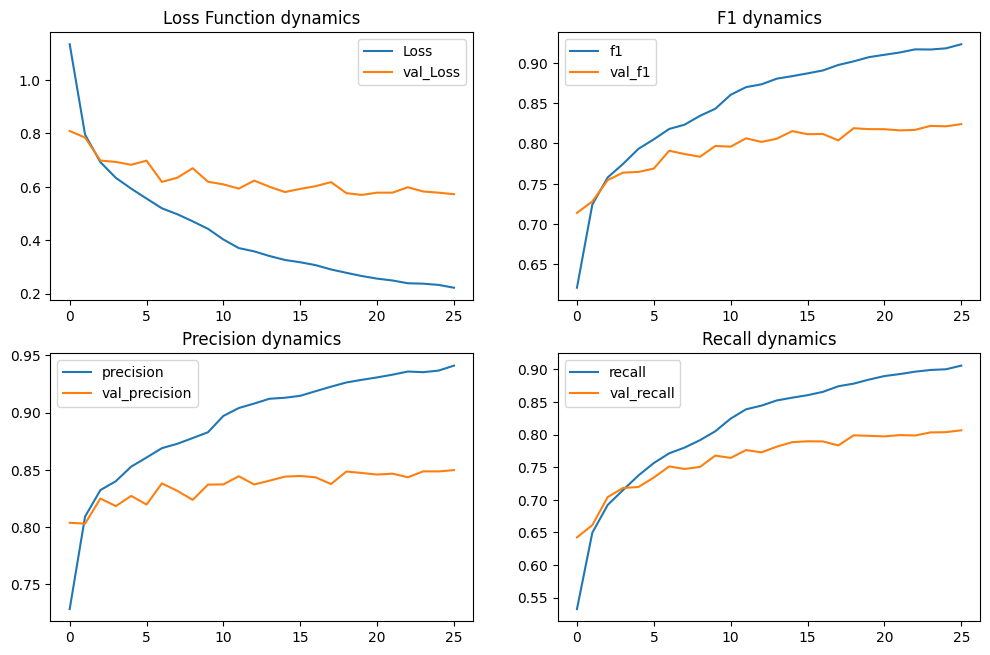

In [96]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_2.history['loss'], label='Loss')
plt.plot(history_2.history['val_loss'], label='val_Loss')
plt.title('Loss Function dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot((np.mean(history_2.history['f1_2'],axis = 1)), label='f1')
plt.plot((np.mean(history_2.history['val_f1_2'],axis = 1)), label='val_f1')
plt.title('F1 dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_2.history['precision_2'], label='precision')
plt.plot(history_2.history['val_precision_2'], label='val_precision')
plt.title('Precision dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_2.history['recall_2'], label='recall')
plt.plot(history_2.history['val_recall_2'], label='val_recall')
plt.title('Recall dynamics')
plt.legend();

In [54]:
preds = second_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       217
           1       0.91      0.92      0.92       206
           2       0.72      0.69      0.71       214
           3       0.63      0.56      0.60       201
           4       0.70      0.80      0.75       190
           5       0.71      0.74      0.72       189
           6       0.83      0.91      0.87       199
           7       0.92      0.84      0.88       180
           8       0.88      0.89      0.88       190
           9       0.94      0.88      0.91       214

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



- Графики валидации почти сразу уходят в плато, а графики трейна все время идут вверх
- в принципе графики похожи на графики из 1 эксперимента
- метрики чуть-чуть выше чем в эксперименте 1, но разница настолько незначительна, что можно сказать, что они одинаковые. По итогу это будут лучшие метркии среди всех экспериментов в ДЗ 1 и ДЗ 3
- early-stop сработал на 26 эпохе, так что модель отработала на 1 минуту быстрее, чем в 1 эксперименте

# Эксперимент 3

- То же самое, но с 10% датасета

In [55]:
dataset_train_3 = dataset_train.shard(num_shards=10, index=0)

In [56]:
backbone.load_weights('weights/backbone')

In [57]:
# Классификатор

inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(128, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.25)(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

third_model = keras.models.Model(inputs = inputs, outputs = output)
third_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 4, 4, 128)         288800    
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 Dense_1 (Dense)             (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 552362 (2.11 MB)
Trainable params: 551466 (2.

In [58]:
third_model.compile(keras.optimizers.legacy.Adam(0.0005),
                    loss="categorical_crossentropy",
                    metrics=[keras.metrics.F1Score(name='f1_3'),
                             keras.metrics.Precision(name='precision_3'),
                             keras.metrics.Recall(name='recall_3'),
                             keras.metrics.Accuracy(name='accuracy_3')])

In [59]:
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/Exp_3")

In [60]:
%%time
history_3 = third_model.fit(dataset_train_3,
                            validation_data=dataset_valid,
                            epochs=50,
                            callbacks=[learn_rate_red, early_stop])

Epoch 1/50
20/20 [==============================] - 3s 75ms/step - loss: 2.2865 - f1_3: 0.2748 - precision_3: 0.3703 - recall_3: 0.1260 - accuracy_3: 0.0000e+00 - val_loss: 3.9352 - val_f1_3: 0.1114 - val_precision_3: 0.1765 - val_recall_3: 0.1395 - val_accuracy_3: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/50
20/20 [==============================] - 1s 54ms/step - loss: 1.6927 - f1_3: 0.3975 - precision_3: 0.5997 - recall_3: 0.1867 - accuracy_3: 0.0000e+00 - val_loss: 2.7259 - val_f1_3: 0.2196 - val_precision_3: 0.3156 - val_recall_3: 0.2037 - val_accuracy_3: 0.0000e+00 - lr: 5.0000e-04
Epoch 3/50
20/20 [==============================] - 1s 63ms/step - loss: 1.5151 - f1_3: 0.4584 - precision_3: 0.6086 - recall_3: 0.2600 - accuracy_3: 0.0000e+00 - val_loss: 2.0450 - val_f1_3: 0.3477 - val_precision_3: 0.4543 - val_recall_3: 0.2862 - val_accuracy_3: 0.0000e+00 - lr: 5.0000e-04
Epoch 4/50
20/20 [==============================] - 1s 72ms/step - loss: 1.4364 - f1_3: 0.4913 - precision_3: 0.6574 -

In [61]:
eval_hist_3 = third_model.evaluate(dataset_test)

8/8 [==============================] - 0s 11ms/step - loss: 0.9487 - f1_3: 0.6697 - precision_3: 0.7500 - recall_3: 0.6045 - accuracy_3: 0.0000e+00


In [62]:
print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_3[0],
                                                                                      eval_hist_3[1],
                                                                                      eval_hist_3[2],
                                                                                      eval_hist_3[3]))

Eval_loss = 0.9486538767814636 
Eval_f1 = [0.74129355 0.8252427  0.49751243 0.45595858 0.5671641  0.5683646
 0.721174   0.7235294  0.7894737  0.80751175] 
Eval_precision = 0.75 
Eval_recall = 0.6044999957084656


#### Графики эксперимент 3

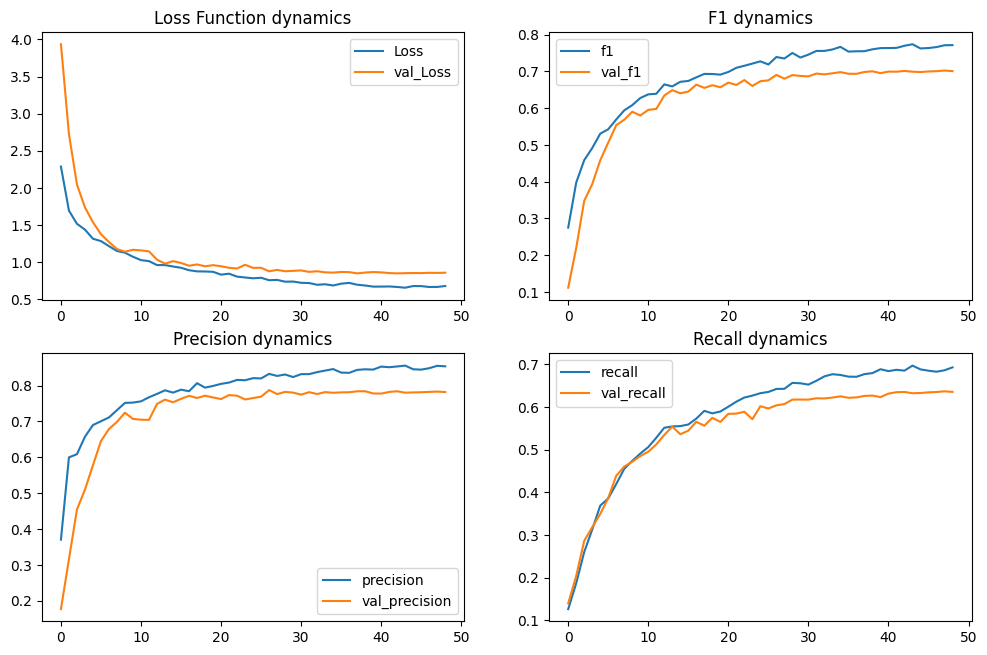

In [97]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_3.history['loss'], label='Loss')
plt.plot(history_3.history['val_loss'], label='val_Loss')
plt.title('Loss Function dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot((np.mean(history_3.history['f1_3'],axis = 1)), label='f1')
plt.plot((np.mean(history_3.history['val_f1_3'],axis = 1)), label='val_f1')
plt.title('F1 dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_3.history['precision_3'], label='precision')
plt.plot(history_3.history['val_precision_3'], label='val_precision')
plt.title('Precision dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_3.history['recall_3'], label='recall')
plt.plot(history_3.history['val_recall_3'], label='val_recall')
plt.title('Recall dynamics')
plt.legend();

In [64]:
preds = third_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

              precision    recall  f1-score   support

           0       0.81      0.69      0.74       217
           1       0.83      0.83      0.83       206
           2       0.53      0.47      0.50       214
           3       0.48      0.44      0.46       201
           4       0.54      0.60      0.57       190
           5       0.58      0.56      0.57       189
           6       0.62      0.86      0.72       199
           7       0.77      0.68      0.72       180
           8       0.79      0.79      0.79       190
           9       0.81      0.80      0.81       214

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



- графики валидации, в отличие от экспериментов 1 и 2, очень близки к графикам трейна
- в целом плато достигается гораздо позже, early-stop  был на предпослежней, 49-й, эпохе
- метрики ниже, чем в первых двух экспериментах
- по времени это самая быстрая модель, но это объясняется очень быстрыми эпохами

# Итоги

- С помощью feature extractor мы смогли значительно сократить время обучения и получить метрики чуть лучше чем в ДЗ 1
- Разница в метриках между моделями 1 и 2 настолько незначительна, что можно сказать, что они проявляют себя одинаково
- Обе эти модели, тем не менее, быстрее достигают плато

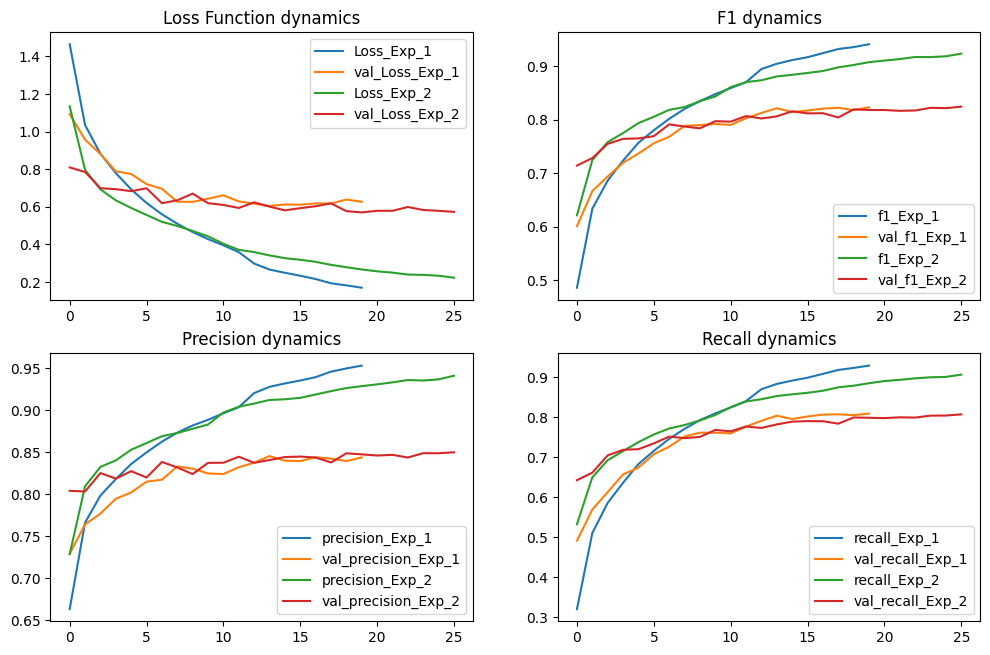

In [94]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_1.history['loss'], label='Loss_Exp_1')
plt.plot(history_1.history['val_loss'], label='val_Loss_Exp_1')
plt.plot(history_2.history['loss'], label='Loss_Exp_2')
plt.plot(history_2.history['val_loss'], label='val_Loss_Exp_2')
plt.title('Loss Function dynamics')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot((np.mean(history_1.history['f1_1'],axis = 1)), label='f1_Exp_1')
plt.plot((np.mean(history_1.history['val_f1_1'],axis = 1)), label='val_f1_Exp_1')
plt.plot((np.mean(history_2.history['f1_2'],axis = 1)), label='f1_Exp_2')
plt.plot((np.mean(history_2.history['val_f1_2'],axis = 1)), label='val_f1_Exp_2')
plt.title('F1 dynamics')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_1.history['precision_1'], label='precision_Exp_1')
plt.plot(history_1.history['val_precision_1'], label='val_precision_Exp_1')
plt.plot(history_2.history['precision_2'], label='precision_Exp_2')
plt.plot(history_2.history['val_precision_2'], label='val_precision_Exp_2')
plt.title('Precision dynamics')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_1.history['recall_1'], label='recall_Exp_1')
plt.plot(history_1.history['val_recall_1'], label='val_recall_Exp_1')
plt.plot(history_2.history['recall_2'], label='recall_Exp_2')
plt.plot(history_2.history['val_recall_2'], label='val_recall_Exp_2')
plt.title('Recall dynamics')
plt.legend();

- На графиках выше видно, что модели из экспериментов 1 и 2 ведут себя одинаково

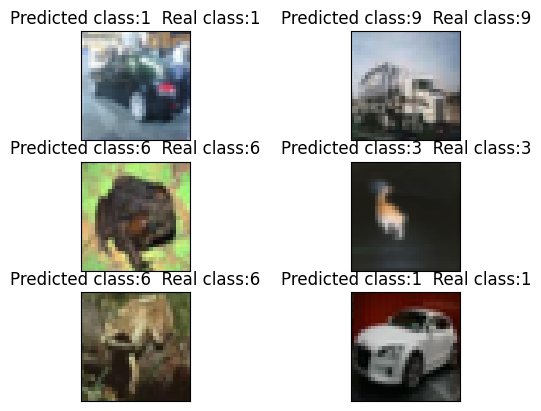

In [74]:
# Пример работы модели из эксперимента 1

h, w = (2, 3)
fig, axs = plt.subplots(w, h)
for i in range(w):
    for j in range(h):
        num = np.random.randint(2000)
        pred = first_model.predict(np.expand_dims(X_test[num], axis=0), verbose=0)
        pred = np.argmax(pred)
        y_test_idx = np.argmax(y_test[num])
        axs[i, j].imshow(X_test[num])
        axs[i, j].set_title('Predicted class:'+str(pred)+'  Real class:'+str(y_test_idx))
        axs[i, j].set(xticks=[], yticks=[])

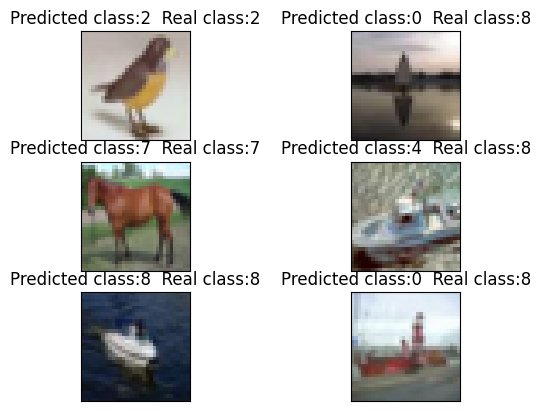

In [89]:
# Пример работы модели из эксперимента 2

h, w = (2, 3)
fig, axs = plt.subplots(w, h)
for i in range(w):
    for j in range(h):
        num = np.random.randint(2000)
        pred = second_model.predict(np.expand_dims(X_test[num], axis=0), verbose=0)
        pred = np.argmax(pred)
        y_test_idx = np.argmax(y_test[num])
        axs[i, j].imshow(X_test[num])
        axs[i, j].set_title('Predicted class:'+str(pred)+'  Real class:'+str(y_test_idx))
        axs[i, j].set(xticks=[], yticks=[])